In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle

In [2]:
# load data
train_ads = pd.read_csv('./train_data_ads.csv.zip', compression='zip')

In [3]:
X = train_ads.drop(['gender'], axis=1)
y = train_ads['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
# get synthetic data from ctgan 
synthetic_data = pd.read_csv('RF_Top5_CTGAN_data.csv')
synthetic_X = synthetic_data.drop(columns=['gender'])
synthetic_y = synthetic_data['gender']
features = synthetic_X.columns

Train logistic regression on only synthetic data and predict on real data

In [7]:
lr = LogisticRegression(class_weight='balanced')
pipeline = Pipeline(steps=[
    ('classifier', lr)
])
param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__solver': ['saga'],
    'classifier__C': np.arange(0.1, 1, 0.2),
    'classifier__warm_start': [False],
    'classifier__max_iter': [1000]
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=3
)
grid_search.fit(synthetic_X, synthetic_y)
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
with open('./ctgan/lr_synth_ctgan_rftop5.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'classifier__C': 0.7000000000000001, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'classifier__warm_start': False}


In [9]:
lr_ctgan_synth = best_model

Precision for 2: [0.77491254 0.77491355 0.77493803 ... 1.         1.         1.        ]
Recall for 2: [1.00000000e+00 1.00000000e+00 9.99985989e-01 ... 8.63055992e-05
 5.38008930e-05 0.00000000e+00]
Precision for 3: [0.07176018 0.07176099 0.07176382 ... 0.         0.         1.        ]
Recall for 3: [1. 1. 1. ... 0. 0. 0.]
Precision for 4: [0.15332729 0.15332975 0.15333561 ... 0.76851852 1.         1.        ]
Recall for 4: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.35087521e-04
 8.49713930e-06 0.00000000e+00]


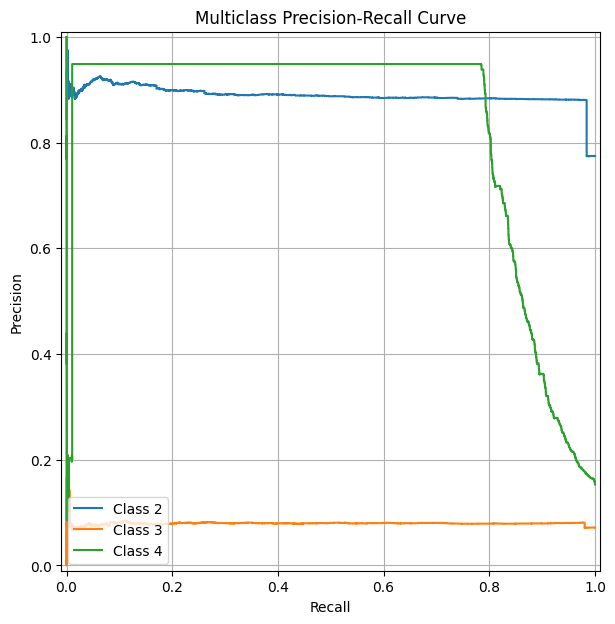

In [18]:
# evaluate model trained on synthetic data from ctgan
y_test_bin = label_binarize(y_test, classes=[2, 3, 4])
features = synthetic_X.columns

# Step 4: Get predicted probabilities for each class
y_prob = lr_ctgan_synth.predict_proba(X_test[features])

# Step 5: Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 7))

for i in range(y_prob.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    print(f'Precision for {i+2}: {precision}')
    print(f'Recall for {i+2}: {recall}')
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot(ax=plt.gca(), name=f'Class {i+2}')

# Step 6: Add plot details
plt.title('Multiclass Precision-Recall Curve')
plt.grid(True)
plt.savefig('./ctgan/plots/PRcurve_ctgan_rftop5_synth.pdf', bbox_inches='tight')
plt.show()

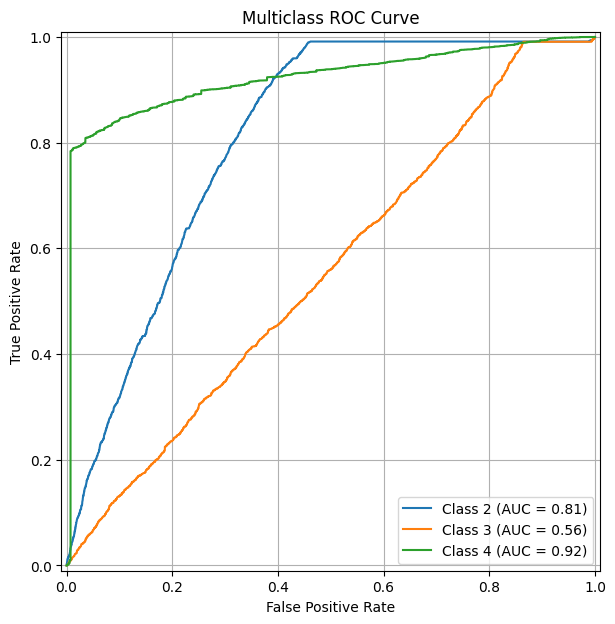

In [17]:
plt.figure(figsize=(10, 7))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i+2}')
    display.plot(ax=plt.gca())

# Step 7: Add plot details
plt.title('Multiclass ROC Curve')
plt.grid(True)
plt.savefig('./ctgan/plots/ROCcurve_ctgan_rftop5_synth.pdf', bbox_inches='tight')
plt.show()

In [12]:
y_pred = lr_ctgan_synth.predict(X_test[features])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.89      0.53      0.66   1784357
           3       0.08      0.32      0.13    165239
           4       0.52      0.85      0.65    353060

    accuracy                           0.57   2302656
   macro avg       0.50      0.57      0.48   2302656
weighted avg       0.77      0.57      0.62   2302656



In [ ]:
y_pred = lr_ctgan_synth.predict(X_test[features])
plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[2, 3, 4])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix', fontsize=12)
plt.savefig('./ctgan/plots/Confusion_ctgan_rftop5_synth.pdf', bbox_inches='tight')  # Save as PDF
plt.show()

Train logistic regression on synthetic and real data and predict on real data

In [15]:
lr = LogisticRegression(class_weight='balanced')
pipeline = Pipeline(steps=[
    ('classifier', lr)
])
param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__solver': ['saga'],
    'classifier__C': np.arange(0.1, 1, 0.2),
    'classifier__warm_start': [False],
    'classifier__max_iter': [1000]
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=3
)

X_train_combined = pd.concat([X_train[features], synthetic_X])
y_train_combined = pd.concat([y_train, synthetic_y])

grid_search.fit(X_train_combined, y_train_combined)
print(f"Best Parameters: {grid_search.best_params_}")
lr_ctgan_real_synth = grid_search.best_estimator_
with open('./ctgan/lr_real_synth_ctgan_rftop5.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END classifier__C=0.30000000000000004, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.498 total time= 2.3min
[CV 2/5] END classifier__C=0.7000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.499 total time= 2.3min
[CV 3/5] END classifier__C=0.9000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.500 total time= 2.3min
[CV 2/5] END classifier__C=0.9000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.498 total time= 2.4min
[CV 4/5] END classifier__C=0.9000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.501 total time= 2.4min
[CV 3/5] END c

Precision for 2: [0.77491254 0.77492129 0.77494577 ... 1.         1.         1.        ]
Recall for 2: [1.00000000e+00 1.00000000e+00 9.99985989e-01 ... 2.39862315e-04
 5.60425969e-06 0.00000000e+00]
Precision for 3: [0.07176018 0.07176099 0.07176102 ... 0.32432432 1.         1.        ]
Recall for 3: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.17866242e-04
 2.17866242e-04 0.00000000e+00]
Precision for 4: [0.15332729 0.15332975 0.15333002 ... 0.80916031 1.         1.        ]
Recall for 4: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.00232255e-04
 7.36418739e-05 0.00000000e+00]


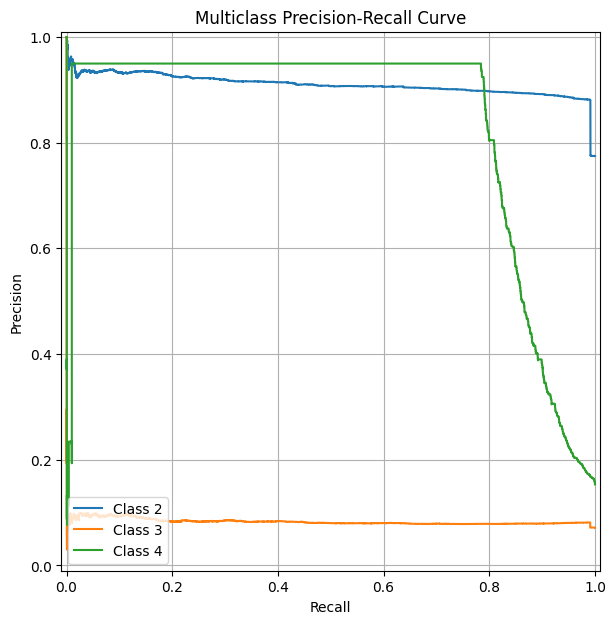

In [16]:
# evaluate model trained on real and synthetic data from ctgan
y_test_bin = label_binarize(y_test, classes=[2, 3, 4])
features = synthetic_X.columns

# Step 4: Get predicted probabilities for each class
y_prob = lr_ctgan_real_synth.predict_proba(X_test[features])

# Step 5: Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 7))

for i in range(y_prob.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    print(f'Precision for {i+2}: {precision}')
    print(f'Recall for {i+2}: {recall}')
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot(ax=plt.gca(), name=f'Class {i+2}')

# Step 6: Add plot details
plt.title('Multiclass Precision-Recall Curve')
plt.grid(True)
plt.savefig('./ctgan/plots/PRcurve_ctgan_rftop5_real_synth.pdf', bbox_inches='tight')
plt.show()

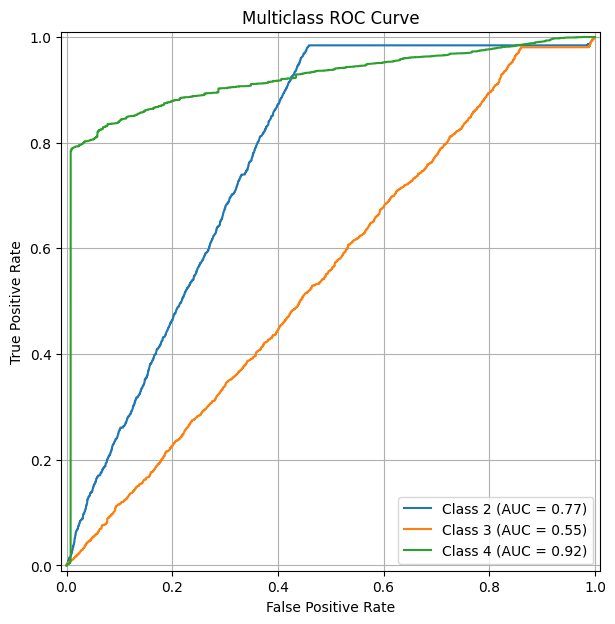

[CV 5/5] END classifier__C=0.5000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.588 total time=27.1min


In [19]:
plt.figure(figsize=(10, 7))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i+2}')
    display.plot(ax=plt.gca())

# Step 7: Add plot details
plt.title('Multiclass ROC Curve')
plt.grid(True)
plt.savefig('./ctgan/plots/ROCcurve_ctgan_rftop5_real_synth.pdf', bbox_inches='tight')
plt.show()

In [20]:
y_pred = lr_ctgan_real_synth.predict(X_test[features])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.90      0.44      0.59   1784357
           3       0.08      0.43      0.14    165239
           4       0.53      0.86      0.65    353060

    accuracy                           0.50   2302656
   macro avg       0.50      0.58      0.46   2302656
weighted avg       0.79      0.50      0.57   2302656



In [ ]:
y_pred = lr_ctgan_real_synth.predict(X_test[features])
plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[2, 3, 4])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix', fontsize=12)
plt.savefig('./ctgan/plots/Confusion_ctgan_rftop5_real_synth.pdf', bbox_inches='tight')  # Save as PDF
plt.show()

Train model on only real data for random forest top 5 features

In [7]:
lr = LogisticRegression(class_weight='balanced')
pipeline = Pipeline(steps=[
    ('classifier', lr)
])
param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__solver': ['saga'],
    'classifier__C': np.arange(0.1, 1, 0.2),
    'classifier__warm_start': [False],
    'classifier__max_iter': [1000]
}
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=3
)


grid_search.fit(X_train[features], y_train)
print(f"Best Parameters: {grid_search.best_params_}")
lr_ctgan_real = grid_search.best_estimator_
with open('./ctgan/lr_real_ctgan_rftop5.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 5/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.577 total time=29.6min
[CV 2/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.579 total time=31.3min


/u/home/a/alisonki/.conda/envs/stats261/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/u/home/a/alisonki/.conda/envs/stats261/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/u/home/a/alisonki/.conda/envs/stats261/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/u/home/a/alisonki/.conda/envs/stats261/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/u/home/a/alisonki/.conda/envs/stats261/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

[CV 4/5] END classifier__C=0.30000000000000004, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.612 total time=53.0min
[CV 2/5] END classifier__C=0.5000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.610 total time=53.1min
[CV 3/5] END classifier__C=0.5000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.584 total time=53.1min
[CV 4/5] END classifier__C=0.5000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.583 total time=53.1min
[CV 1/5] END classifier__C=0.9000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.574 total time=53.1min
[CV 2/5] END classifier__C=0.7000000000000001, classifier__max_iter=1000, 

/u/home/a/alisonki/.conda/envs/stats261/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.7000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.581 total time=19.7min
[CV 5/5] END classifier__C=0.9000000000000001, classifier__max_iter=1000, classifier__penalty=l2, classifier__solver=saga, classifier__warm_start=False;, score=0.571 total time=50.7min
Best Parameters: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'classifier__warm_start': False}


/u/home/a/alisonki/.conda/envs/stats261/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<Figure size 800x800 with 0 Axes>

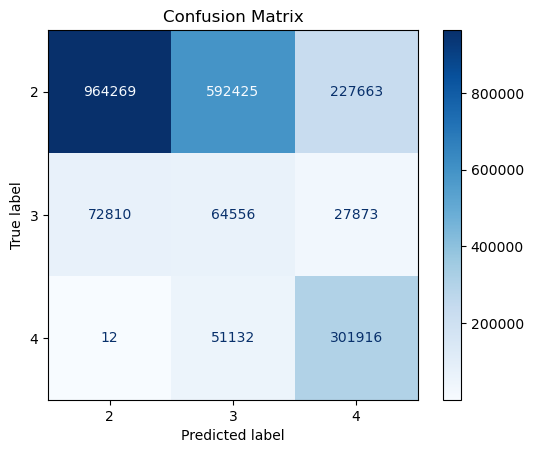

In [12]:
y_pred = lr_ctgan_real.predict(X_test[features])
plt.figure(figsize=(8, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[2, 3, 4])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix', fontsize=12)
plt.savefig('./ctgan/plots/Confusion_ctgan_rftop5_real.pdf', bbox_inches='tight')  # Save as PDF
plt.show()

Precision for 2: [0.77491254 0.77492129 0.77492119 ... 0.4        1.         1.        ]
Recall for 2: [1.00000000e+00 1.00000000e+00 9.99999440e-01 ... 1.12085194e-06
 1.12085194e-06 0.00000000e+00]
Precision for 3: [0.07176018 0.07176099 0.07176102 ... 0.         0.         1.        ]
Recall for 3: [1. 1. 1. ... 0. 0. 0.]
Precision for 4: [0.15332729 0.15332975 0.15333002 ... 0.96296296 1.         1.        ]
Recall for 4: [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 7.36418739e-05
 7.36418739e-05 0.00000000e+00]


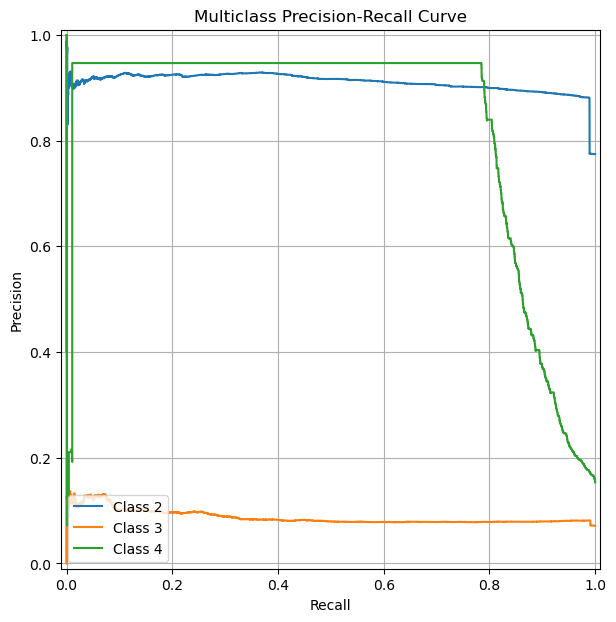

In [13]:
# evaluate model trained on real data
y_test_bin = label_binarize(y_test, classes=[2, 3, 4])
features = synthetic_X.columns

# Step 4: Get predicted probabilities for each class
y_prob = lr_ctgan_real.predict_proba(X_test[features])

# Step 5: Plot Precision-Recall curves for each class
plt.figure(figsize=(10, 7))

for i in range(y_prob.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    print(f'Precision for {i+2}: {precision}')
    print(f'Recall for {i+2}: {recall}')
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot(ax=plt.gca(), name=f'Class {i+2}')

# Step 6: Add plot details
plt.title('Multiclass Precision-Recall Curve')
plt.grid(True)
plt.savefig('./ctgan/plots/PRcurve_ctgan_rftop5_real.pdf', bbox_inches='tight')
plt.show()

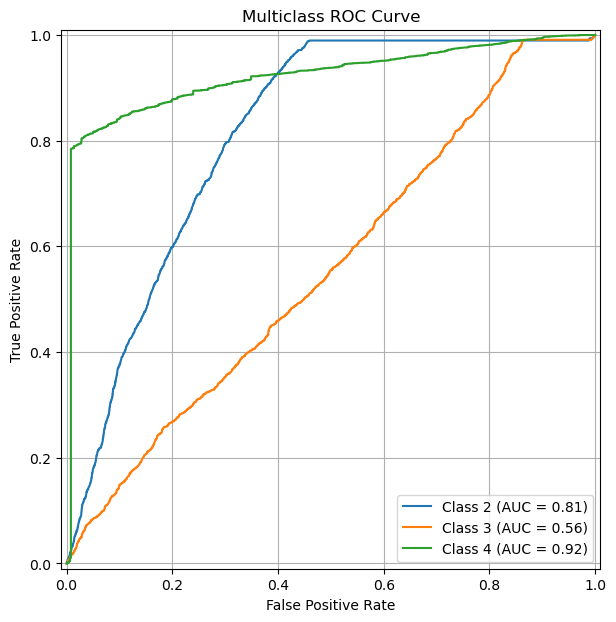

In [14]:
plt.figure(figsize=(10, 7))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i+2}')
    display.plot(ax=plt.gca())

# Step 7: Add plot details
plt.title('Multiclass ROC Curve')
plt.grid(True)
plt.savefig('./ctgan/plots/ROCcurve_ctgan_rftop5_real.pdf', bbox_inches='tight')
plt.show()

In [15]:
y_pred = lr_ctgan_real.predict(X_test[features])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.93      0.54      0.68   1784357
           3       0.09      0.39      0.15    165239
           4       0.54      0.86      0.66    353060

    accuracy                           0.58   2302656
   macro avg       0.52      0.60      0.50   2302656
weighted avg       0.81      0.58      0.64   2302656

